In [ ]:
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import os
import sys

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA L4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# this should take ~ 3 minutes
!mkdir -p /content/data/
!cp "/content/drive/MyDrive/ML Project/data/image/sampled_jpg.zip" /content/data/

In [ ]:
# another ~ 3 minutes. Clear the 220k lines of output!
!mkdir -p /content/data/images/
!unzip /content/data/sampled_jpg.zip -d /content/data/images/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/images/fb5ecdbcc97a048454dc1eda9e0519bc027e9d9cc8c62a121a7250d73efd849b.jpg  
  inflating: /content/data/images/fb5ed7c92aff8be4c8841b61f4317fd2a2fb1466d9d1354b70114460366d1b72.jpg  
  inflating: /content/data/images/fb5ed841c39fa15a2ed9ba7bd8c64b1121aa66fbf1903c3ee5958f366c2ef3a8.jpg  
  inflating: /content/data/images/fb5f047f1a8e911e216e294407089d37354ca170e87411463f020f15e924db29.jpg  
  inflating: /content/data/images/fb5f2e4389feed76be0daa719966041525cd9a3baf7da42294c455b1a2011771.jpg  
  inflating: /content/data/images/fb6004c79db1133fb8f5ea86d137f13f3c5bad146e745474d07faa9da7a9736e.jpg  
  inflating: /content/data/images/fb612e132fc2739f3ade810fdb642e24565992eb3c72261b220337b3eb6635a2.jpg  
  inflating: /content/data/images/fb618dee4744876a9248263f8dd47d895fe6266dfb07b43922568f95e9297cb3.jpg  
  inflating: /content/data/images/fb619e17fbf908b61e74f24e2ce44e6bba134733695cc74bc24735e21b313c79.jpg  
  in

# Load data

### Check resolution

In [ ]:
image_dir = "/content/data/images/"

In [ ]:
image_name_path = "/content/drive/MyDrive/ML Project/data/image/images_sample"

In [ ]:
image_files = (
    image_dir + pd.read_csv(image_name_path, header=None)
).iloc[:, 0].to_list()

In [ ]:
image_files[0]

'/content/data/images/12781c410afa225d4a845df2ea4a27b10c9de8bc684e40df77f32f499a5c78e2.jpg'

In [ ]:
# Check resolutions for the first 100 files

resolutions = []
for image_path in tqdm(image_files[0:100], desc="Checking image resolutions"):
    try:
        with Image.open(image_path) as img:
            resolution = img.size  # (width, height)
            resolutions.append(resolution)
    except Exception as e:
        print(f"{image_path}: {e}")
np.array(resolutions).mean(axis=0)

Checking image resolutions: 100%|██████████| 100/100 [00:00<00:00, 2271.77it/s]


array([403.5 , 420.25])

### Load and transform

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()
dataset = ImageDataset(image_files, transform=transform)
dataloader = DataLoader(dataset, batch_size=512, shuffle=False, pin_memory=True)

# Feature Extraction

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # headless
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
all_features = []
with torch.no_grad():
    for batch in tqdm(dataloader, desc="Extracting Features", unit="batch"):
        batch = batch.to(device)
        features = model(batch).squeeze()
        all_features.append(features.cpu())

# Combine all features
features = torch.cat(all_features, dim=0).numpy()

Extracting Features: 100%|██████████| 544/544 [26:17<00:00,  2.90s/batch]


In [ ]:
print(features.shape)

(278167, 2048)


In [ ]:
np.save("/content/drive/MyDrive/ML Project/data/image/features.npy", features)

# SVD on image features

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
features = np.load("/content/drive/MyDrive/ML Project/data/image/features.npy")
print(features.shape)

(278167, 2048)


100%|██████████| 9/9 [05:58<00:00, 39.82s/it]


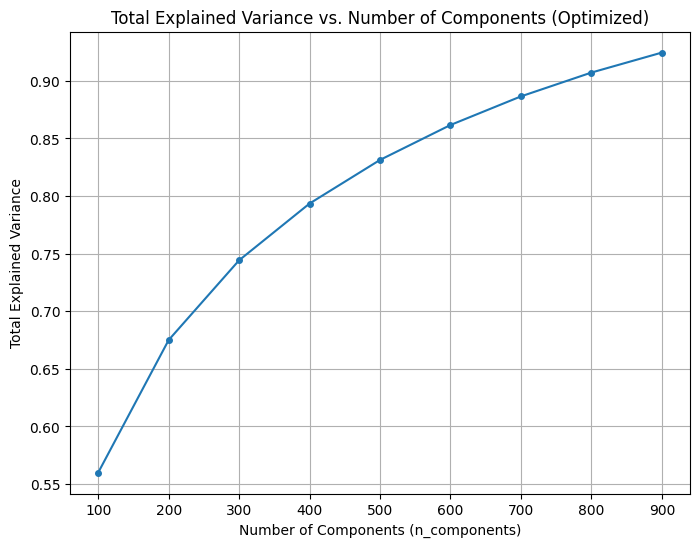

In [ ]:
explained_variances = []
n_components_range = range(100, 1000, 100)
for n_components in tqdm(n_components_range):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(features)
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
plt.plot(n_components_range, explained_variances, marker='o', linestyle='-', markersize=4)
plt.title("Total Explained Variance vs. Number of Components (Optimized)")
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Total Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
n_components = 500
svd = TruncatedSVD(n_components=n_components, random_state=42)

features_svd = svd.fit_transform(features)

total_explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance by {n_components} components: {total_explained_variance:.2f}")

Total explained variance by 500 components: 0.83


# Merge with train and test index

In [ ]:
features_svd = pd.DataFrame(features_svd, columns=[f"image_svd_{i}" for i in range(n_components)])

In [ ]:
features_svd['image'] = pd.read_csv(image_name_path, header=None).iloc[:, 0].str[:-4]  # -4 to remove .jpg
features_svd

,image_svd_0,image_svd_1,image_svd_2,image_svd_3,image_svd_4,image_svd_5,image_svd_6,image_svd_7,image_svd_8,image_svd_9,...,image_svd_491,image_svd_492,image_svd_493,image_svd_494,image_svd_495,image_svd_496,image_svd_497,image_svd_498,image_svd_499,image
0,4.691186,-2.030960,4.426165,-0.817080,-3.668704,-0.552479,-1.103454,-0.443852,1.813357,0.003952,...,-0.004598,0.208308,0.292718,-0.105684,-0.002159,-0.124015,0.098852,-0.013726,-0.175648,12781c410afa225d4a845df2ea4a27b10c9de8bc684e40...
1,2.481168,-1.692893,2.299149,1.988902,4.017269,-0.699203,-0.188648,0.342375,3.307604,-0.828218,...,-0.046375,-0.072828,0.156109,0.019473,0.136714,-0.047132,-0.147890,-0.103522,0.028437,3f9aa10cb333a56904d3ea4c2217cd39beb2d8fed96d11...
2,4.960140,3.555624,0.856267,-0.829887,0.592307,-1.493159,0.654597,0.087168,0.221795,-1.134049,...,0.099671,0.236513,-0.205241,-0.089389,0.152781,-0.229816,-0.063724,-0.062986,0.194176,62a226f33a59fed479441aadd6756b60faabd7a5000c05...
3,2.618013,-0.609841,-1.909148,4.014044,-1.283454,-2.571677,-1.754392,0.408727,-0.788512,-0.513948,...,0.113375,0.134049,-0.103559,-0.007717,-0.078480,0.013974,-0.022630,0.214887,0.179783,22d8c6d363be31927407fe6a377119728f839812aa4b25...
4,3.444181,-1.911901,3.558614,3.026534,5.542298,-0.721903,-0.887602,0.182427,3.031434,-0.546587,...,-0.020343,-0.104912,0.197427,-0.051967,0.032089,0.163593,0.155468,0.170217,0.054013,6cafc9d350bfc830e33bb17bc5d3b537f471356e451fc0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278162,5.947352,-4.112437,5.401837,-0.723240,-1.781269,-0.254264,-1.173631,-1.047431,-1.585306,-0.491567,...,0.335963,0.534930,-0.004587,0.067766,0.149677,0.242511,-0.075395,0.376189,0.306672,f865a1b96702620ba7f9fea0a530081a8c9f292be6ec71...
278163,5.631135,4.261900,0.074347,-0.439295,-0.062706,1.013887,-1.050897,-1.666214,0.729994,0.059448,...,0.135113,0.288366,-0.434240,-0.174688,-0.272907,0.228002,-0.030048,-0.227927,-0.237872,61255f9942fb0b6364ab23909dcf3098f829a7f639f3d0...
278164,2.604044,-1.112527,1.269568,1.151498,0.291985,0.213576,0.717255,-0.397771,-0.469615,0.923365,...,0.249376,0.274616,0.076236,-0.023610,-0.148944,-0.095524,-0.098708,0.171659,-0.185322,20f26f215d679d798d8957fc0a7c10ee7dfb5fc93005fd...
278165,2.587032,-1.656927,0.002545,-1.481112,0.319017,-1.944744,0.223249,0.575896,0.420678,0.449609,...,0.263862,0.045674,-0.064125,-0.011309,0.245972,-0.096758,-0.084619,-0.076450,0.030070,36b29c02fb12501b9808fdad478888fa488e403b2964bb...


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/ML Project/data/image/train_image_sample")
train_df = train_df.loc[:, ["image"]]
test_df = pd.read_csv("/content/drive/MyDrive/ML Project/data/image/test_image_sample")
test_df = test_df.loc[:, ["image"]]

train_df = train_df.merge(features_svd, on="image", how="left")
test_df = test_df.merge(features_svd, on="image", how="left")

In [ ]:
assert not train_df.isna().any().any()
assert not test_df.isna().any().any()

In [ ]:
train_df.to_csv("/content/drive/MyDrive/ML Project/data/image/train_image_svd.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/ML Project/data/image/test_image_svd.csv", index=False)